In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sbe_vallib import Validation, BinaryScorer, SupervisedSampler

## Dataset

In [35]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

X, y = make_classification(n_samples=120, n_classes=2,
                               n_features=5, n_informative=3, n_redundant=0,
                               random_state=0)

X = pd.DataFrame(X)
y = pd.Series(y)

X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)


In [36]:
len(X_train), len(X_test), len(X_val)

(75, 12, 33)

## Model

In [37]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train, y_train)

## Sampler Scorer

In [38]:
from sbe_vallib import SupervisedSampler, BinaryScorer

sampler = SupervisedSampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                            oos={'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)},
                            oot={'X': X_val, 'y_true': y_val, 'y_pred': model.predict_proba(X_val)})

scorer = BinaryScorer()

In [50]:
from sbe_vallib.table.model_quality.test_ci import test_ci

def custom_test(model, scorer, sampler, threshold = 1, **kwargs):
    semaphore = 'green'
    if len(sampler.train['X']) < threshold:
        semaphore = 'red'
    
    df_table = pd.DataFrame({'len': [len(sampler.train['X'])],
                             'semaphore': semaphore})
    
    return {
        "semaphore": semaphore,
        "result_dict": {'train_shape':sampler.train['X'].values.shape},
        "result_dataframes": [df_table],
        "result_plots": [],
    }


custom_tests = {
    "custom_1": {"block": "data_quality", "callable": custom_test, "params": {"threshold": 5000}},
    "custom_test_ci": {"block": "model_quality", "callable": test_ci, "params": {"gen_method": "bootstrap"}},
}



validor = Validation(model, sampler, scorer, custom_tests=custom_tests,
                         pipeline='../src/sbe_vallib/table/pipelines/Config_31.xlsx')
res = validor.validate()
res.keys()

/Users/azatsultanov/Programming/vallib/vallib_env/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


TypeError: Cannot index by location index with a non-integer key

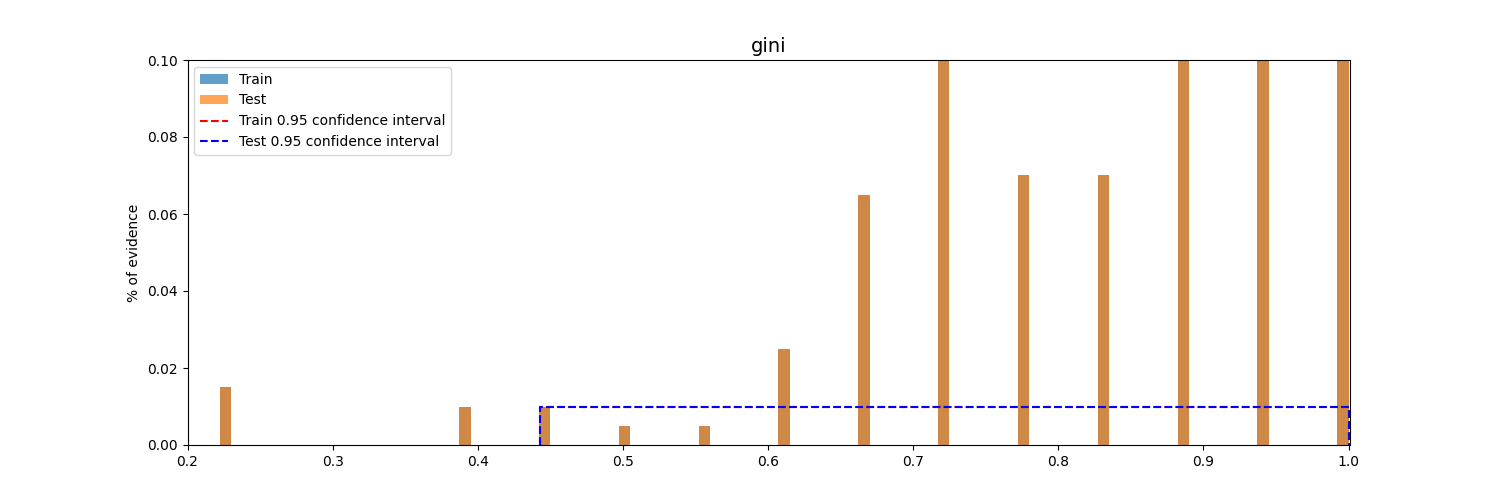

In [49]:
res['test_ci']['result_plots'][0]